# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 3: benchmarking on audio dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

# audio signal augmentation packages
import audiomentations
import torch_audiomentations
from audiomentations import Compose, AddGaussianNoise, HighPassFilter, BandPassFilter, LoudnessNormalization
from audiomentations import Normalize, Gain

from torch_audiomentations import PolarityInversion

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

from audio_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns
from itertools import cycle
import itertools


# Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
# Multimodal_dataset_PATH = os.path.join("/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset")
# Image_path = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'images')
# Audio_raw_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'raw_audio')
# Audio_equalized_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'equalized_audio')
# Audio_bandpassed_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'bandpassed_audio')
# Audio_denoised_seg_PATH = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'denoised_audio')

# AUDIO_DIR = Audio_denoised_seg_PATH
# VISON_DIR = Image_path

# torch.manual_seed(0)

# ANNOTATIONS_FILE = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', "visual_acoustic_dataset_annotations_v2.csv")

In [2]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'segmented_25Hz/{sample_number}'))
    return sample_directories

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
samples = [21, 22, 23, 26]
sample_directories = get_sample_directories(Multimodal_dataset_PATH, samples)

# Get lists of image and audio directories for each sample
image_directories = [os.path.join(sample_dir, 'images') for sample_dir in sample_directories]
audio_directories = [os.path.join(sample_dir, 'equalized_audio') for sample_dir in sample_directories]

In [3]:
# classes = ('Laser-off', 'Defect-free', 'Defective')
classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 50

### Utils functions

In [4]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'train_audio')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

### Use GPU if possible

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
mp.set_start_method(method='forkserver', force=True)

Using cpu


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [6]:
# Combine all annotation files into one DataFrame
all_annotation_dfs = []
for sample_dir, sample_number in zip(sample_directories, samples):
    annotation_file = os.path.join(sample_dir, f'annotations_{sample_number}.csv')  # Update the file name
    annotation_df = pd.read_csv(annotation_file)
    all_annotation_dfs.append(annotation_df)
combined_annotation_df = pd.concat(all_annotation_dfs)

combined_annotation_df = combined_annotation_df.dropna(subset=['name'])
combined_annotation_df

,sample index,audio_file_name,image_file_name,name,class_ID,class_name_v2,class_ID_2,Layer number,Sample number,class_ID_v2
0,1,sample_21_1.wav,sample_21_1.jpg,Laser-off,0.0,Laser-off,0.0,1.0,21,NaN
1,2,sample_21_2.wav,sample_21_2.jpg,Crack,2.0,Defective,2.0,1.0,21,NaN
2,3,sample_21_3.wav,sample_21_3.jpg,Crack,2.0,Defective,2.0,1.0,21,NaN
3,4,sample_21_4.wav,sample_21_4.jpg,Crack,2.0,Defective,2.0,1.0,21,NaN
4,5,sample_21_5.wav,sample_21_5.jpg,Defect-free,1.0,Defect-free,1.0,1.0,21,NaN
...,...,...,...,...,...,...,...,...,...,...
10981,10982,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,NaN,NaN,NaN,284.0,26,NaN
10982,10983,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,NaN,NaN,NaN,285.0,26,NaN
10983,10984,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,NaN,NaN,NaN,286.0,26,NaN
10984,10985,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,NaN,NaN,NaN,287.0,26,NaN


In [7]:
# Get the labels and count the number of samples for each class
labels = combined_annotation_df['name'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[1100 6580 4512 7914]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **43%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [8]:
### Get the percentage distribution of each category
round(combined_annotation_df.groupby('name')["name"].count()/combined_annotation_df.shape[0]*100, 1)

name
Crack             5.5
Defect-free      32.7
Keyhole pores    22.4
Laser-off        39.4
Name: name, dtype: float64

Saving figure dataset


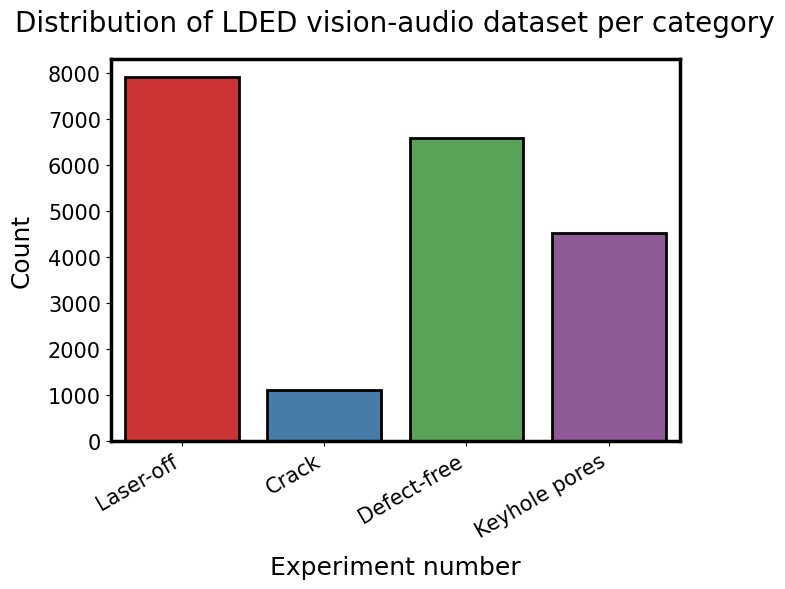

In [9]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='name', data = combined_annotation_df, palette="Set1", linewidth=2,
                   edgecolor='k'); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of LDED vision-audio dataset per category', fontsize = 20, pad=20);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset")

## Preparing Dataset and DataLoader

In [10]:
#------ transformation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)



augmentation = Compose(
    [
       AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=0.5),
       # HighPassFilter(min_cutoff_freq=1000, max_cutoff_freq=21000, p=0.5),
       BandPassFilter(min_center_freq=1000, max_center_freq=21000, p=0.5),
       # Gain(min_gain_in_db = -2, max_gain_in_db = 2, p=0.5),
       Normalize(p=0.5)
    ]
)


# Initialize augmentation callable
apply_augmentation = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        PolarityInversion(p=0.5)
    ]
)

train_transform = transforms.Compose([
    # augmentation,
    # apply_augmentation,
    # torchaudio.transforms.TimeMasking(time_mask_param=20, p=0.5),  # apply time masking with probability of 0.5
    # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),  # apply time masking with probability of 0.5
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=32),  # compute Mel-frequency cepstral coefficients (MFCCs)
])


In [11]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(combined_annotation_df,
                                audio_directories,
                                samples,
                                mel_spectrogram,
                                # MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

length of the total dataset:20106


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [12]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(combined_annotation_df, labels))

# split the data into train and test sets
train_annotations = combined_annotation_df.iloc[train_indices, :]
test_annotations = combined_annotation_df.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = LDEDAudioDataset(train_annotations,
                                 audio_directories,
                                 samples, 
                                 mel_spectrogram,
                                 SAMPLE_RATE,
                                 device=device)

val_dataset = LDEDAudioDataset(test_annotations,
                               audio_directories,
                               samples,
                               mel_spectrogram,
                               SAMPLE_RATE,
                               device=device)

### Create DataLoader using the dataset

In [13]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:16084
length of the val dataset:4022


## Training the model

In [14]:
resume = False
start_epoch = 0
best_acc = 0

In [15]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
    # train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
    # test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
    # scheduler.step()

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

==> Building model..

Epoch: 0


Epoch 0:   0%|                | 0/126 [00:13<?, ?it/s, loss=1.27, accuracy=39.9]


10:33:59 --- Epoch: 0	Train loss: 1.3016	Valid loss: 0.0397	Train accuracy: 36.20	Valid accuracy: 39.93

Epoch: 1


Epoch 1:   0%|                | 0/126 [00:12<?, ?it/s, loss=1.24, accuracy=52.1]


10:36:20 --- Epoch: 1	Train loss: 1.2573	Valid loss: 0.0388	Train accuracy: 45.46	Valid accuracy: 52.09

Epoch: 2


Epoch 2:   0%|                  | 0/126 [00:12<?, ?it/s, loss=1.22, accuracy=53]


10:38:40 --- Epoch: 2	Train loss: 1.2343	Valid loss: 0.0382	Train accuracy: 51.13	Valid accuracy: 52.96

Epoch: 3


Epoch 3:   0%|                | 0/126 [00:12<?, ?it/s, loss=1.21, accuracy=53.6]


10:40:59 --- Epoch: 3	Train loss: 1.2145	Valid loss: 0.0378	Train accuracy: 53.00	Valid accuracy: 53.56

Epoch: 4


Epoch 4:   0%|                | 0/126 [00:12<?, ?it/s, loss=1.19, accuracy=54.5]


10:43:22 --- Epoch: 4	Train loss: 1.1981	Valid loss: 0.0374	Train accuracy: 54.15	Valid accuracy: 54.50

Epoch: 5


Epoch 5:   0%|                | 0/126 [00:12<?, ?it/s, loss=1.18, accuracy=55.2]


10:45:41 --- Epoch: 5	Train loss: 1.1858	Valid loss: 0.0371	Train accuracy: 55.02	Valid accuracy: 55.25

Epoch: 6


Epoch 6:   0%|                | 0/126 [00:12<?, ?it/s, loss=1.16, accuracy=57.2]


10:48:02 --- Epoch: 6	Train loss: 1.1712	Valid loss: 0.0364	Train accuracy: 56.24	Valid accuracy: 57.24

Epoch: 7


Epoch 7:   0%|                | 0/126 [00:12<?, ?it/s, loss=1.14, accuracy=58.9]


10:50:25 --- Epoch: 7	Train loss: 1.1509	Valid loss: 0.0356	Train accuracy: 58.88	Valid accuracy: 58.90

Epoch: 8


Epoch 8:   0%|                | 0/126 [00:12<?, ?it/s, loss=1.11, accuracy=62.9]


10:52:47 --- Epoch: 8	Train loss: 1.1280	Valid loss: 0.0348	Train accuracy: 61.93	Valid accuracy: 62.85

Epoch: 9


Epoch 9:   0%|                | 0/126 [00:13<?, ?it/s, loss=1.08, accuracy=65.3]


10:55:08 --- Epoch: 9	Train loss: 1.1027	Valid loss: 0.0339	Train accuracy: 64.98	Valid accuracy: 65.34

Epoch: 10


Epoch 10:   0%|                 | 0/126 [00:13<?, ?it/s, loss=1.06, accuracy=69]


10:57:31 --- Epoch: 10	Train loss: 1.0802	Valid loss: 0.0332	Train accuracy: 67.37	Valid accuracy: 68.97

Epoch: 11


Epoch 11:   0%|               | 0/126 [00:12<?, ?it/s, loss=1.05, accuracy=70.9]


10:59:51 --- Epoch: 11	Train loss: 1.0597	Valid loss: 0.0328	Train accuracy: 69.44	Valid accuracy: 70.86

Epoch: 12


Epoch 12:   0%|                 | 0/126 [00:12<?, ?it/s, loss=1.01, accuracy=74]


11:02:12 --- Epoch: 12	Train loss: 1.0402	Valid loss: 0.0317	Train accuracy: 71.64	Valid accuracy: 73.97

Epoch: 13


Epoch 13:   0%|                  | 0/126 [00:12<?, ?it/s, loss=1, accuracy=75.2]


11:04:34 --- Epoch: 13	Train loss: 1.0280	Valid loss: 0.0314	Train accuracy: 72.90	Valid accuracy: 75.24

Epoch: 14


Epoch 14:   0%|              | 0/126 [00:13<?, ?it/s, loss=0.988, accuracy=76.3]


11:06:55 --- Epoch: 14	Train loss: 1.0142	Valid loss: 0.0310	Train accuracy: 74.40	Valid accuracy: 76.33

Epoch: 15


Epoch 15:   0%|                | 0/126 [00:12<?, ?it/s, loss=0.979, accuracy=78]


11:09:15 --- Epoch: 15	Train loss: 1.0028	Valid loss: 0.0307	Train accuracy: 75.63	Valid accuracy: 78.02

Epoch: 16


Epoch 16:   0%|              | 0/126 [00:12<?, ?it/s, loss=0.969, accuracy=78.9]


11:11:34 --- Epoch: 16	Train loss: 0.9910	Valid loss: 0.0304	Train accuracy: 76.68	Valid accuracy: 78.87

Epoch: 17


Epoch 17:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.961, accuracy=79.8]


11:13:47 --- Epoch: 17	Train loss: 0.9821	Valid loss: 0.0301	Train accuracy: 77.60	Valid accuracy: 79.81

Epoch: 18


Epoch 18:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.956, accuracy=80.2]


11:14:22 --- Epoch: 18	Train loss: 0.9754	Valid loss: 0.0299	Train accuracy: 78.11	Valid accuracy: 80.23

Epoch: 19


Epoch 19:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.953, accuracy=80.2]


11:14:57 --- Epoch: 19	Train loss: 0.9674	Valid loss: 0.0298	Train accuracy: 78.90	Valid accuracy: 80.16

Epoch: 20


Epoch 20:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.952, accuracy=80.1]


11:15:33 --- Epoch: 20	Train loss: 0.9638	Valid loss: 0.0298	Train accuracy: 79.27	Valid accuracy: 80.08

Epoch: 21


Epoch 21:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.945, accuracy=80.9]


11:16:08 --- Epoch: 21	Train loss: 0.9605	Valid loss: 0.0296	Train accuracy: 79.45	Valid accuracy: 80.93

Epoch: 22


Epoch 22:   0%|                | 0/126 [00:08<?, ?it/s, loss=0.941, accuracy=81]


11:16:43 --- Epoch: 22	Train loss: 0.9557	Valid loss: 0.0295	Train accuracy: 79.94	Valid accuracy: 81.00

Epoch: 23


Epoch 23:   0%|               | 0/126 [00:08<?, ?it/s, loss=0.94, accuracy=81.1]


11:17:18 --- Epoch: 23	Train loss: 0.9528	Valid loss: 0.0294	Train accuracy: 80.12	Valid accuracy: 81.13

Epoch: 24


Epoch 24:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.937, accuracy=81.6]


11:17:53 --- Epoch: 24	Train loss: 0.9511	Valid loss: 0.0294	Train accuracy: 80.09	Valid accuracy: 81.60

Epoch: 25


Epoch 25:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.937, accuracy=81.4]


11:18:29 --- Epoch: 25	Train loss: 0.9479	Valid loss: 0.0293	Train accuracy: 80.25	Valid accuracy: 81.35

Epoch: 26


Epoch 26:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.934, accuracy=81.7]


11:19:05 --- Epoch: 26	Train loss: 0.9460	Valid loss: 0.0293	Train accuracy: 80.43	Valid accuracy: 81.65

Epoch: 27


Epoch 27:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.934, accuracy=81.7]


11:19:40 --- Epoch: 27	Train loss: 0.9444	Valid loss: 0.0293	Train accuracy: 80.60	Valid accuracy: 81.65

Epoch: 28


Epoch 28:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.932, accuracy=81.8]


11:20:17 --- Epoch: 28	Train loss: 0.9419	Valid loss: 0.0292	Train accuracy: 80.81	Valid accuracy: 81.75

Epoch: 29


Epoch 29:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.934, accuracy=81.6]


11:20:56 --- Epoch: 29	Train loss: 0.9400	Valid loss: 0.0293	Train accuracy: 81.02	Valid accuracy: 81.60

Epoch: 30


Epoch 30:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.932, accuracy=81.8]


11:21:32 --- Epoch: 30	Train loss: 0.9399	Valid loss: 0.0292	Train accuracy: 81.02	Valid accuracy: 81.80

Epoch: 31


Epoch 31:   0%|               | 0/126 [00:08<?, ?it/s, loss=0.93, accuracy=81.8]


11:22:07 --- Epoch: 31	Train loss: 0.9374	Valid loss: 0.0291	Train accuracy: 81.16	Valid accuracy: 81.75

Epoch: 32


Epoch 32:   0%|               | 0/126 [00:08<?, ?it/s, loss=0.93, accuracy=81.9]


11:22:42 --- Epoch: 32	Train loss: 0.9375	Valid loss: 0.0291	Train accuracy: 81.17	Valid accuracy: 81.90

Epoch: 33


Epoch 33:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.929, accuracy=82.1]


11:23:18 --- Epoch: 33	Train loss: 0.9345	Valid loss: 0.0291	Train accuracy: 81.39	Valid accuracy: 82.10

Epoch: 34


Epoch 34:   0%|               | 0/126 [00:08<?, ?it/s, loss=0.93, accuracy=81.8]


11:23:52 --- Epoch: 34	Train loss: 0.9354	Valid loss: 0.0291	Train accuracy: 81.25	Valid accuracy: 81.80

Epoch: 35


Epoch 35:   0%|                | 0/126 [00:08<?, ?it/s, loss=0.928, accuracy=82]


11:24:27 --- Epoch: 35	Train loss: 0.9336	Valid loss: 0.0291	Train accuracy: 81.50	Valid accuracy: 82.00

Epoch: 36


Epoch 36:   0%|              | 0/126 [00:09<?, ?it/s, loss=0.927, accuracy=82.1]


11:25:04 --- Epoch: 36	Train loss: 0.9326	Valid loss: 0.0290	Train accuracy: 81.58	Valid accuracy: 82.07

Epoch: 37


Epoch 37:   0%|                | 0/126 [00:08<?, ?it/s, loss=0.928, accuracy=82]


11:25:40 --- Epoch: 37	Train loss: 0.9318	Valid loss: 0.0291	Train accuracy: 81.58	Valid accuracy: 82.00

Epoch: 38


Epoch 38:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.926, accuracy=82.1]


11:26:16 --- Epoch: 38	Train loss: 0.9320	Valid loss: 0.0290	Train accuracy: 81.60	Valid accuracy: 82.12

Epoch: 39


Epoch 39:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.929, accuracy=81.8]


11:26:54 --- Epoch: 39	Train loss: 0.9314	Valid loss: 0.0291	Train accuracy: 81.69	Valid accuracy: 81.82

Epoch: 40


Epoch 40:   0%|                | 0/126 [00:08<?, ?it/s, loss=0.927, accuracy=82]


11:27:32 --- Epoch: 40	Train loss: 0.9306	Valid loss: 0.0290	Train accuracy: 81.74	Valid accuracy: 82.05

Epoch: 41


Epoch 41:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.925, accuracy=82.1]


11:28:07 --- Epoch: 41	Train loss: 0.9306	Valid loss: 0.0290	Train accuracy: 81.63	Valid accuracy: 82.15

Epoch: 42


Epoch 42:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.926, accuracy=82.1]


11:28:43 --- Epoch: 42	Train loss: 0.9286	Valid loss: 0.0290	Train accuracy: 81.96	Valid accuracy: 82.15

Epoch: 43


Epoch 43:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.925, accuracy=82.2]


11:29:18 --- Epoch: 43	Train loss: 0.9296	Valid loss: 0.0290	Train accuracy: 81.77	Valid accuracy: 82.20

Epoch: 44


Epoch 44:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.925, accuracy=82.3]


11:30:07 --- Epoch: 44	Train loss: 0.9290	Valid loss: 0.0290	Train accuracy: 81.86	Valid accuracy: 82.30

Epoch: 45


Epoch 45:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.924, accuracy=82.3]


11:30:47 --- Epoch: 45	Train loss: 0.9284	Valid loss: 0.0289	Train accuracy: 81.84	Valid accuracy: 82.30

Epoch: 46


Epoch 46:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.925, accuracy=82.1]


11:31:27 --- Epoch: 46	Train loss: 0.9271	Valid loss: 0.0290	Train accuracy: 82.00	Valid accuracy: 82.12

Epoch: 47


Epoch 47:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.927, accuracy=81.9]


11:32:04 --- Epoch: 47	Train loss: 0.9277	Valid loss: 0.0290	Train accuracy: 81.84	Valid accuracy: 81.95

Epoch: 48


Epoch 48:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.924, accuracy=82.3]


11:32:42 --- Epoch: 48	Train loss: 0.9262	Valid loss: 0.0289	Train accuracy: 82.19	Valid accuracy: 82.27

Epoch: 49


Epoch 49:   0%|              | 0/126 [00:08<?, ?it/s, loss=0.925, accuracy=82.1]

11:33:20 --- Epoch: 49	Train loss: 0.9257	Valid loss: 0.0290	Train accuracy: 82.13	Valid accuracy: 82.15


In [16]:
valid_accuracy

[39.93038289408255,
 52.08851317752362,
 52.958727001491795,
 53.55544505221283,
 54.500248632521135,
 55.24614619592243,
 57.23520636499254,
 58.90104425658876,
 62.854301342615614,
 65.34062655395326,
 68.97066136250622,
 70.86026852312283,
 73.96817503729488,
 75.23620089507708,
 76.33018398806564,
 78.02088513177523,
 78.86623570363004,
 79.81103928393834,
 80.23371456986574,
 80.15912481352561,
 80.08453505718548,
 80.92988562904029,
 81.0044753853804,
 81.12879164594729,
 81.60119343610144,
 81.35256091496768,
 81.6509199403282,
 81.6509199403282,
 81.7503729487817,
 81.60119343610144,
 81.80009945300846,
 81.7503729487817,
 81.89955246146197,
 82.09845847836897,
 81.80009945300846,
 81.99900546991546,
 82.07359522625559,
 81.99900546991546,
 82.12332173048235,
 81.82496270512183,
 82.04873197414221,
 82.14818498259572,
 82.14818498259572,
 82.19791148682248,
 82.29736449527599,
 82.29736449527599,
 82.12332173048235,
 81.9492789656887,
 82.27250124316261,
 82.14818498259572]

Saving figure train_lost_curve_audio


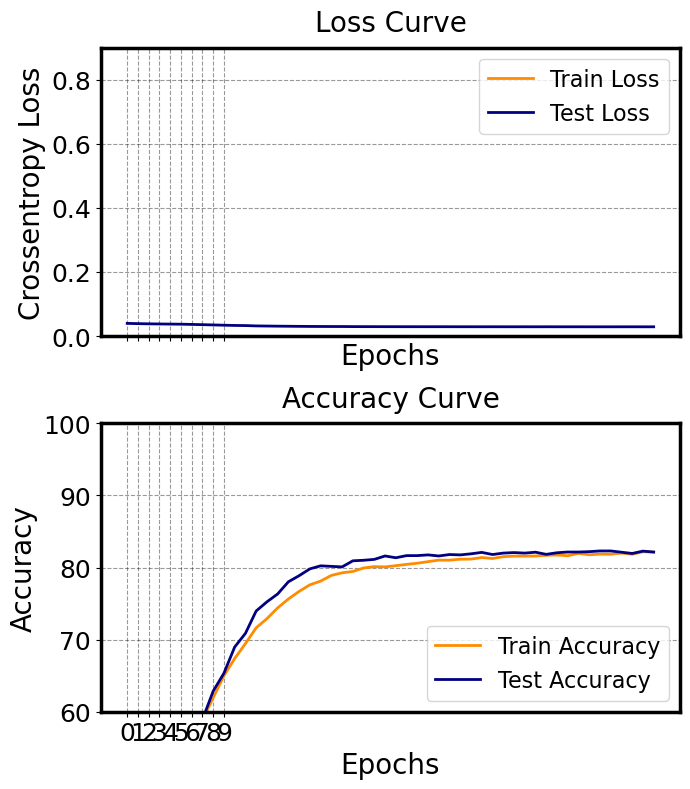

In [17]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 9, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=0.9, yacc_limit1=60, yacc_limit2=100)

save_fig ("train_lost_curve_audio")

In [18]:
get_accuracy(model, val_dataloader, device)

0.8214818498259573

Test Accuracy (cross-validation) for MFCC-CNN = 0.82148 ± 0.00883
micro-averaging AUC for MFCC-CNN = 0.89306 ± 0.00000
Saving figure ROC_curve (acoustic-based)


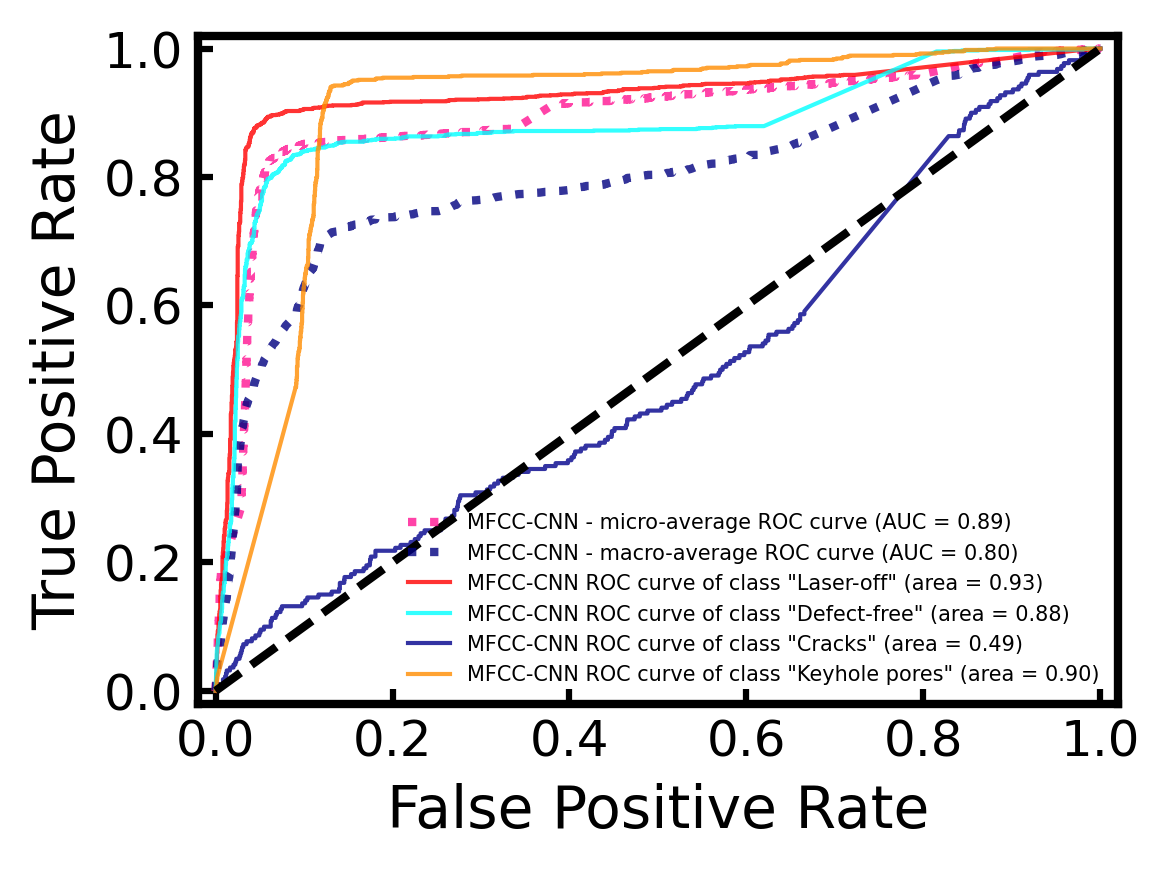

In [19]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", signal_type = "denoised", seed=0)

save_fig ("ROC_curve (acoustic-based)")

In [20]:
yt, yp = class_report(model, val_dataloader, device, classes)

               precision    recall  f1-score   support

       Cracks     0.0000    0.0000    0.0000       220
  Defect-free     0.8702    0.7895    0.8279      1316
Keyhole pores     0.6719    0.9413    0.7841       903
    Laser-off     0.9053    0.8939    0.8996      1583

     accuracy                         0.8215      4022
    macro avg     0.6119    0.6562    0.6279      4022
 weighted avg     0.7919    0.8215    0.8010      4022



[[   0   73  111   36]
 [   0 1039  197   80]
 [   0   21  850   32]
 [   0   61  107 1415]]
Saving figure confusion_matrix(audio_based)


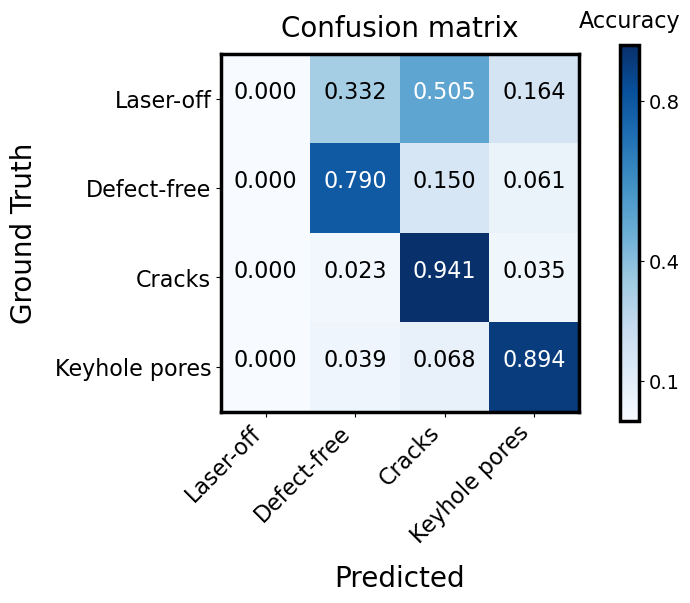

In [21]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_based)")